# CNN 5 - Pooling from scratch

- Dataset:
    - https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset
- The dataset isn't deep-learning-compatible by default, here's how to preprocess it:
    - Video: https://www.youtube.com/watch?v=O7EV2BjOXus&ab_channel=BetterDataScience
    - Article: https://towardsdatascience.com/tensorflow-for-image-classification-top-3-prerequisites-for-deep-learning-projects-34c549c89e42
    - Code: https://github.com/better-data-science/TensorFlow/blob/main/008_CNN_001_Working_With_Image_Data.ipynb

- Today we'll implement pooling from scratch in pure Python and Numpy
- Pooling boils down to subseting 2D array into smaller chunks, which should be easy to implement
- You'll need only Numpy for now:

In [1]:
import numpy as np

- Let's declare a simple and small 2D array that will represent an output from a convolutional layer:

In [2]:
conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

- To start with pooling, you'll have to select values for two hyperparameters:
    - `pool_size` - A size of the single region that slides over the image
    - `stride` - The number of pixels you want the region to move as it goes over the image
    
- Common sizes are 2x2 for the pool size, and 2 for the stride
- Choosing these value will reduce the convolutional output size by half!
- Pool size of 2x2 and a stride of 1 will reduce the image size by a single pixel, which doesn't make much sense

<br>

## Extract pools from a 2D array
- Let's first take care of extracting individual pools
    - Matrices of shape (pool size, pool size)
- Pool size = 2
- Stride = 2

In [3]:
# Define paramters
pool_size = 2
stride = 2

# For all rows with the step size of 2 (row 0 and row 2)
for i in np.arange(conv_output.shape[0], step=stride):
    # For all columns with the step size of 2 (column 0 and column 2)
    for j in np.arange(conv_output.shape[0], step=stride):
        # Get a single pool
        # First  - Image[0:2, 0:2] -> [[10, 12], [ 4, 11]]
        # Second - Image[0:2, 2:4] -> [[ 8,  7], [ 5,  9]]
        # Third  - Image[2:4, 0:2] -> [[18, 13], [ 3, 15]]
        # Fourth - Image[2:4, 2:4] -> [[ 7,  7], [ 2,  2]]
        mat = conv_output[i:i+pool_size, j:j+pool_size]
        
        # Ensure that the shape of the matrix is 2x2 (pool size)
        if mat.shape == (pool_size, pool_size):
            # Print it
            print(mat)
    # Print a new line when the code reaches the end of a single row block
    print()

[[10 12]
 [ 4 11]]
[[8 7]
 [5 9]]

[[18 13]
 [ 3 15]]
[[7 7]
 [2 2]]



- Simple, right? 
- Let's see what happens if we change the stride value to 1
- We'll keep everything else as is:

In [4]:
pool_size = 2
stride = 1

for i in np.arange(conv_output.shape[0], step=stride):
    for j in np.arange(conv_output.shape[0], step=stride):
        mat = conv_output[i:i+pool_size, j:j+pool_size]
        if mat.shape == (pool_size, pool_size):
            print(mat)
    print()

[[10 12]
 [ 4 11]]
[[12  8]
 [11  5]]
[[8 7]
 [5 9]]

[[ 4 11]
 [18 13]]
[[11  5]
 [13  7]]
[[5 9]
 [7 7]]

[[18 13]
 [ 3 15]]
[[13  7]
 [15  2]]
[[7 7]
 [2 2]]




- We now get much more pools, which isn't what we want
- You can't go wrong by starting with the pool size of 2 and stride of 2
- Let's now put all of this in a single function:

In [5]:
def get_pools(img: np.array, pool_size: int, stride: int) -> np.array:
    # To store individual pools
    pools = []
    
    # Iterate over all row blocks (single block has `stride` rows)
    for i in np.arange(img.shape[0], step=stride):
        # Iterate over all column blocks (single block has `stride` columns)
        for j in np.arange(img.shape[0], step=stride):
            
            # Extract the current pool
            mat = img[i:i+pool_size, j:j+pool_size]
            
            # Make sure it's rectangular - has the shape identical to the pool size
            if mat.shape == (pool_size, pool_size):
                # Append to the list of pools
                pools.append(mat)
                
    # Return all pools as a Numpy array
    return np.array(pools)

In [6]:
test_pools = get_pools(img=conv_output, pool_size=2, stride=2)
test_pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

<br>

## MaxPooling from scratch
- MaxPooling is the most common pooling type
- Basically, it keeps only the largest value from a single pool
- There are other types of pooling, such as AveragePooling
    - It's used much less in practice
    - To implement it, replace `np.max()` with `np.mean()`

**MaxPooling logic**
1. Get the total number of pools - length of the `pools` matrix (or `shape[0]`)
2. Calculate target shape - image size after performing the pooling operation
    - Calculted as: Square root of the number of pools casted as integer
    - Why? We need a rectangular matrix
    - If `num_pools` is 16, we need a 4x4 matrix (sqrt(16) = 4)
3. Iterate over all pools and calculate the max - append the max a result list
4. Return the result list as a Numpy array reshaped to the target shape

In [7]:
def max_pooling(pools: np.array) -> np.array:
    # Total number of pools
    num_pools = pools.shape[0]
    # Shape of the matrix after pooling - Square root of the number of pools
    # Cast it to int, as Numpy will return it as float
    # For example -> np.sqrt(16) = 4.0 -> int(4.0) = 4
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    # To store the max values
    pooled = []
    
    # Iterate over all pools
    for pool in pools:
        # Append the max value only
        pooled.append(np.max(pool))
        
    # Reshape to target shape
    return np.array(pooled).reshape(tgt_shape)

- Let's test it out:

In [8]:
max_pooling(pools=test_pools)

array([[12,  9],
       [18,  7]])

- Works like a charm! 
- Let's implement pooling on a real image next

<br>

## Implement pooling on a real image
- Let's import PIL and Matplotlib to make working with images easier
- We'll declare two helper functions for visualizing single image, and two images side by side:

In [9]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray');

- Let's load a sample image from our dataset
- We'll pretend it is an output from a convolutional layer
    - It doesn't matter actually, pooling doesn't know we're faking it
- To make calculations easier, we'll grayscale the image and resize it to 224x224
    - That's a common practice with neural networks:

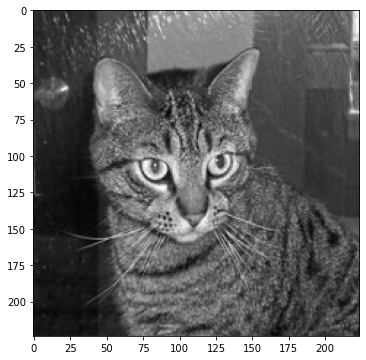

In [10]:
img = Image.open('cat.jpg')
img = ImageOps.grayscale(img)
img = img.resize(size=(224, 224))
plot_image(img=img)

- Let's get the pools next
- Remember to convert the image to a Numpy array
- We'll stick with a pool size of 2 and stride of 2

In [11]:
cat_img_pools = get_pools(img=np.array(img), pool_size=2, stride=2)

In [12]:
cat_img_pools

array([[[39, 41],
        [42, 43]],

       [[41, 41],
        [44, 44]],

       [[41, 42],
        [43, 45]],

       ...,

       [[77, 48],
        [77, 52]],

       [[25, 32],
        [36, 44]],

       [[29, 49],
        [38, 32]]], dtype=uint8)

- Let's see how many pools we have in total:

In [13]:
cat_img_pools.shape

(12544, 2, 2)

- So we have 12544 pools, each being a small 2x2 matrix
- **Square root of 12544 is 112**, which means our image will be of size 112x112 pixels after the pooling operation
- Let's do the pooling:

In [14]:
cat_max_pooled = max_pooling(pools=cat_img_pools)
cat_max_pooled

array([[ 43,  44,  45, ..., 163, 201, 197],
       [ 45,  44,  45, ..., 165, 197, 198],
       [ 43,  37,  38, ..., 165, 185, 200],
       ...,
       [ 24,  19,  19, ...,  76,  78,  43],
       [ 30,  21,  23, ...,  58,  51,  42],
       [ 32,  23,  25, ...,  77,  44,  49]], dtype=uint8)

- Quickly verify the shape:

In [15]:
cat_max_pooled.shape

(112, 112)

- Everything looks right, but let's also visualize the cat image before and after pooling
- We shouldn't have any problems recognizing a cat:

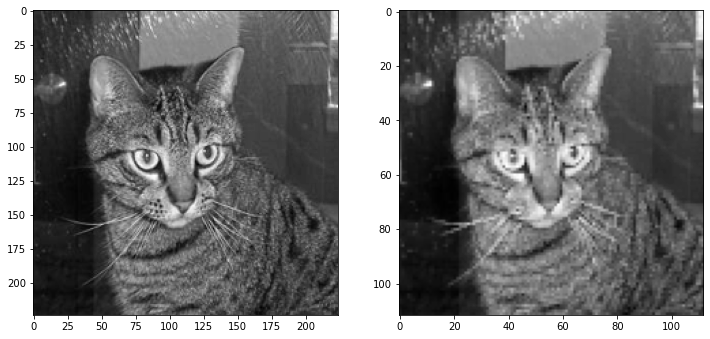

In [16]:
plot_two_images(img1=img, img2=cat_max_pooled)

- **Note**: The image on the right is displayed in same figure size as the image on the left, even though it's smaller - check X and Y axis values
- It's still a cat, so we can verify the pooling worked

**How do we know if we did everything correctly?**
- We can apply TensorFlow's pooling layer to the cat image and compare the matrices

<br>

## Verification - Pooling with TensorFlow
- Let's import TensorFlow to verify we calculated everything correctly:

In [17]:
import tensorflow as tf

- We'll declare a Sequential model that has only a MaxPool2D layer
- Note the parameters:
    - Pool size = 2
    - Strides = 2
- Just as we had during the manual calculation

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
])

- We don't have to train the model
- Before passing in the image, we need to reshape it
    - Batch size, width, height, number of color channels

In [20]:
cat_arr = np.array(img).reshape(1, 224, 224, 1)
cat_arr.shape

(1, 224, 224, 1)

- We can now use the `predict()` function to apply the pooling
- It will return a 1x12x12x1 tensor, so we'll reshape it to 112x112:

In [22]:
output = model.predict(cat_arr).reshape(112, 112)
output

array([[ 43,  44,  45, ..., 163, 201, 197],
       [ 45,  44,  45, ..., 165, 197, 198],
       [ 43,  37,  38, ..., 165, 185, 200],
       ...,
       [ 24,  19,  19, ...,  76,  78,  43],
       [ 30,  21,  23, ...,  58,  51,  42],
       [ 32,  23,  25, ...,  77,  44,  49]], dtype=uint8)

- The matrix does look familiar
- We can now use the `array_equal()` function from Numpy to test if our array equals to TensorFlow's "prediction":

In [23]:
np.array_equal(cat_max_pooled, output)

True

- And it does, which means we did everything correctly!
- You now know how to implement convolutions and pooling from scratch
- There's no need to ever do that, but it's good to know
- The next notebook will cover building a more robust image classifier with TensorFlow